# Functions

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping

import pandas as pd
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Code

In [2]:


def get_val_results():
   
    main_data = pd.read_excel('Validation_Interpolate_Median.xlsx')

  
    results_dir = "./Results_Validation"
    test_data_dir = "./ExcelsPrecision_Median"


    def format_parameters(param):
        return param.replace('_', '', 1)

    def format_frame(frame):
        frame_num = int(frame.split('_')[-1])
        return f"frame_{frame_num:06d}",frame_num


    filtered_data = main_data[main_data['Result'] == 1]


    combined_data = []

 
    for _, row in filtered_data.iterrows():
        video = row['Video']
        raw_frame = row['Frame']
        frame, frame_num = format_frame(raw_frame)
        params = format_parameters(row['Parameters'])

    
        image_path = os.path.join(results_dir, video, video, f"{frame}.png")
        test_data_path = os.path.join(test_data_dir, f"{video}_{params}_comapprox_post_processed_median.xlsx")

 
        if os.path.exists(test_data_path):
            test_data = pd.read_excel(test_data_path, index_col=0)  
            if frame_num in test_data.index:  
                test_row = test_data.loc[frame_num]
                combined_data.append({
                    'Image Path': image_path,
                    'Video': video,
                    'Frame': frame,
                    'Parameters': params,
                    'center_y(ccol)': test_row['center_y(ccol)'],
                    'center_x(crow)': test_row['center_x(crow)'],
                    'circle_radius': test_row['circle_radius']
                })
            else:
                print(f"Warning: Frame {frame_num} not found in {test_data_path}")
        else:
            print(f"Warning: Test data file not found for {test_data_path}")

    # Create DataFrame from combined data
    result_df = pd.DataFrame(combined_data)

    # Save to Excel
    output_path = "combined_results2.xlsx"
    result_df.to_excel(output_path, index=False)
    print(f"Combined results saved to {output_path}")


In [3]:

def build_autoencoder(input_shape=(256, 256, 1)):
   
    input_img = Input(shape=input_shape, name='input_image')


    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)


    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)


    x = Dense(1024, activation='relu')(encoded)
    x = Reshape((4, 4, 64))(x)


    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')




  
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
    return autoencoder


def train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32):
    autoencoder.compile(
        optimizer='adam',
        loss={'image_output': 'mse', 'radius_output': 'mse'}
    )

   
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

   
    history = autoencoder.fit(
        x_train,
        {'image_output': x_train, 'radius_output': radii_train},
        validation_data=(x_val, {'image_output': x_val, 'radius_output': radii_val}),
        epochs=50,
        batch_size=32
    )


    autoencoder.summary()

    return history

# # Example Dataset Preparation (to be replaced with your real data)
# import numpy as np

# # Simulated data for example
# num_samples = 1000
# img_height, img_width = 256, 256

# x_train = np.random.rand(num_samples, img_height, img_width, 1).astype('float32')  # Random grayscale images
# radii_train = np.random.rand(num_samples, 1).astype('float32') * 100  # Random radii between 0 and 100

# x_val = np.random.rand(int(num_samples * 0.2), img_height, img_width, 1).astype('float32')  # Validation images
# radii_val = np.random.rand(int(num_samples * 0.2), 1).astype('float32') * 100  # Validation radii

# # Build, Compile, and Train the Autoencoder
# autoencoder = build_autoencoder(input_shape=(256, 256, 1))
# history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)

# # Save the model for future use
# autoencoder.save('diffraction_autoencoder.h5')

# # Predicting on new data
# test_images = np.random.rand(10, img_height, img_width, 1).astype('float32')  # Example test images
# reconstructed_images, predicted_radii = autoencoder.predict(test_images)

# # Display results
# print("Predicted Radii:", predicted_radii)


In [ ]:



df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values       


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)


autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))  # Function from earlier code
history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)


autoencoder.save('diffraction_autoencoder.h5')


test_images = x_val[:10]  
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - image_output_loss: 0.0576 - loss: 1054.3009 - radius_output_loss: 1038.2731 - val_image_output_loss: 0.0288 - val_loss: 143.5015 - val_radius_output_loss: 103.3875
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - image_output_loss: 0.0325 - loss: 262.1249 - radius_output_loss: 259.1424 - val_image_output_loss: 0.0165 - val_loss: 109.8055 - val_radius_output_loss: 112.1277
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - image_output_loss: 0.0197 - loss: 150.7707 - radius_output_loss: 149.9423 - val_image_output_loss: 0.0113 - val_loss: 127.6066 - val_radius_output_loss: 133.7760
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - image_output_loss: 0.0203 - loss: 94.3010 - radius_output_loss: 93.1707 - val_image_output_loss: 0.0104 - val_loss: 80.6275 - val_radius_output_loss: 58.4521
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - image_output_loss: 0.0173 - loss: 110.3492 - radius_output_loss: 110.3328 - val_image_output_loss: 0.013

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 256, 256,  │        320 │ input_image[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 128, 128,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_features    │ (None, 262144)    │          0 │ max_pooling2d_3[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1024)      │ 268,436,4… │ encoded_features… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 4, 4, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 4, 4, 64)  │     36,928 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_6     │ (None, 8, 8, 64)  │          0 │ conv2d_10[0][0]   │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 8, 8, 64)  │     36,928 │ up_sampling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_7     │ (None, 16, 16,    │          0 │ conv2d_11[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │     18,464 │ up_sampling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_8     │ (None, 32, 32,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │      4,624 │ up_sampling2d_8[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 64, 64,    │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 64, 64, 8) │      1,160 │ up_sampling2d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 128, 128,  │          0 │ conv2d_14[0][0]   │
│ (UpSampling2D)      │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 806,447,624 (3.00 GB)

 Trainable params: 268,815,874 (1.00 GB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 537,631,750 (2.00 GB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Radii: [37.303078 36.63611  36.186066 37.456673 37.310352 36.480198 36.52237
 36.177414 35.293526 35.153343]


In [16]:
print(radii_val[:10])

[[38.993984 ]
 [36.2506446]
 [36.5000622]
 [38.0001896]
 [38.9989406]
 [37.745165 ]
 [39.005028 ]
 [36.9944262]
 [35.2398808]
 [33.995009 ]]


In [18]:
predicted_radii.size

45

ValueError: x and y must be the same size

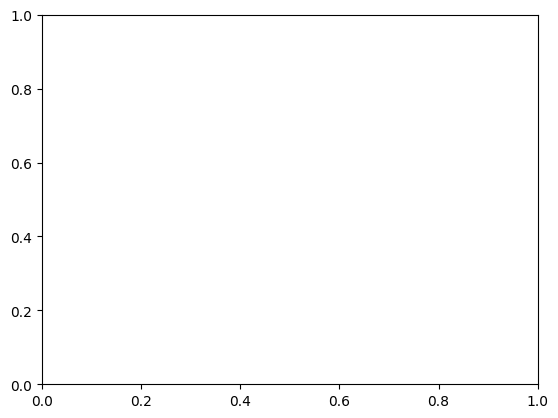

In [17]:


# Plot true vs predicted radii
plt.scatter(radii_val[:10], predicted_radii)
plt.plot([radii_val[:10].min(), radii_val[:10].max()], [radii_val[:10].min(), radii_val[:10].max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


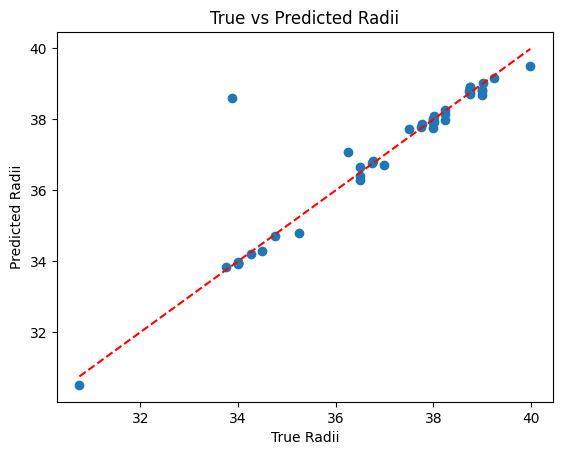

In [3]:
df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['circle_radius'].values       

img_height, img_width = 256, 256 #FIXED DImensions
images = []

for path in image_paths:
   
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)

autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
test_images = x_val
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


plt.scatter(radii_val, predicted_radii)
plt.plot([radii_val.min(), radii_val.max()], [radii_val.min(), radii_val.max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


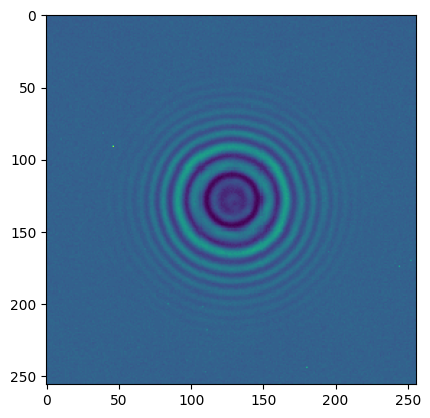

In [13]:
img_height, img_width = 256, 256  
images = []
path = './Results_Validation/VideoLarge/cropped_object_1/frame_000001.png_object1.png'
  
img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
plt.imshow(img)
plt.show()
img_array = img_to_array(img) / 255.0  
images.append(img_array)


images = np.array(images)  

In [8]:
print(autoencoder.predict(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[array([[[[0.5959562 ],
         [0.7509391 ],
         [0.76966053],
         ...,
         [0.6075894 ],
         [0.6446324 ],
         [0.47152147]],

        [[0.900333  ],
         [0.945397  ],
         [0.9380161 ],
         ...,
         [0.8059905 ],
         [0.7892273 ],
         [0.61429864]],

        [[0.89738524],
         [0.95322365],
         [0.93888295],
         ...,
         [0.8151697 ],
         [0.79439664],
         [0.60675544]],

        ...,

        [[0.61931413],
         [0.737577  ],
         [0.75916153],
         ...,
         [0.8708839 ],
         [0.834068  ],
         [0.6038216 ]],

        [[0.6189146 ],
         [0.732866  ],
         [0.75735223],
         ...,
         [0.8569437 ],
         [0.81909144],
         [0.65705717]],

        [[0.60604745],
         [0.66781276],
         [0.70076364],
         ...,
         [0.7224228 ],
         [0.6626278 ],
         [0.5889239 ]]]], dtype=float32), array

In [9]:
import matplotlib.patches as patches
import cv2
from pathlib import Path

image_path='./Results_Validation/VideoLarge/cropped_object_1/frame_000001.png_object1.png'
# image_path='./Results_Validation/Video1/Video1/frame_000000.png'


img_height, img_width = 256, 256
img = load_img(image_path, target_size=(img_height, img_width), color_mode='grayscale')
img_array = img_to_array(img) / 255.0  
images=[]
images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)

# autoencoder = load_model('diffraction_autoencoder_old.keras', custom_objects={'mse': MeanSquaredError()})
# autoencoder = load_model('models/autoencoder_fold_1.h5', custom_objects={'mse': MeanSquaredError()})
# reconstructed_images, predicted_radii,pred_ccol,pred_crow = autoencoder.predict(images)
reconstructed_images, predicted_radii = autoencoder.predict(images)
print(autoencoder.predict(images))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
[array([[[[0.5959562 ],
         [0.7509391 ],
         [0.76966053],
         ...,
         [0.6075894 ],
         [0.6446324 ],
         [0.47152147]],

        [[0.900333  ],
         [0.945397  ],
         [0.9380161 ],
         ...,
         [0.8059905 ],
         [0.7892273 ],
         [0.61429864]],

        [[0.89738524],
         [0.95322365],
         [0.93888295],
         ...,
         [0.8151697 ],
         [0.79439664],
         [0.60675544]],

        ...,

        [[0.61931413],
         [0.737577  ],
         [0.75916153],
         ...,
         [0.8708839 ],
         [0.834068  ],
         [0.6038216 ]],

        [[0.6189146 ],
         [0.732866  ],
         [0.75735223],
         ...,
         [0.8569437 ],
         [0.81909144],
         [0.65705717]],

        [[0.60604745],
         [0.66781276],
         [0.70076364],
         ...,
         [0.7224228 ],
         [0.6626278 ],
         [

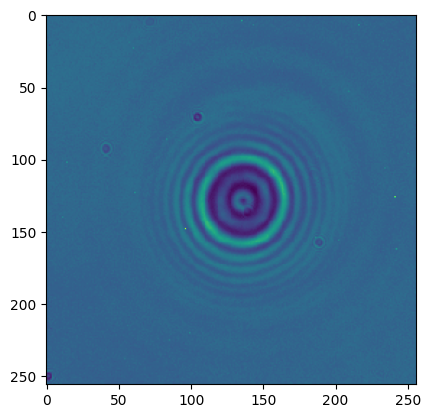

In [12]:
plt.imshow(x_val[1])
plt.show()

In [10]:
x_val[1]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [17]:
radii_val[1]

array([36.2506446])

C:\Users\Tautvydas\AppData\Local\Temp\ipykernel_16224\1501940735.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


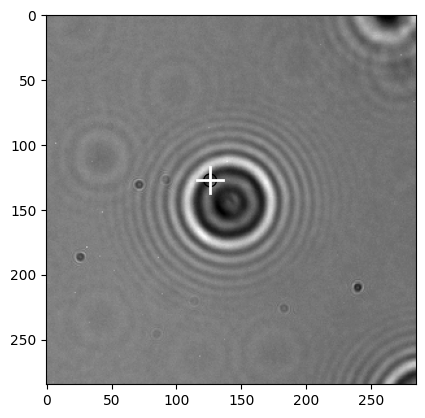

In [11]:

# image=reconstructed_images[0]
image = cv2.imread('./Results_Validation/VideoLarge/cropped_object_1/frame_000000.png_object1.png', cv2.IMREAD_GRAYSCALE)
image = cv2.imread('./Results_Validation/Video1/Video1/frame_000000.png', cv2.IMREAD_GRAYSCALE)
ccol=125.9989183
crow=127.2544289
# plt.imshow(image2)
# plt.show()
# circle_radius=predicted_radii[0]
# circle_radius=pred_crow
fig, ax = plt.subplots()
ax.imshow(image, cmap='gray')
circle_center=(ccol,crow)
circle = patches.Circle(circle_center, predicted_radii, edgecolor='black', facecolor='none', linewidth=1)
ax.add_patch(circle)

cross_size = 10
ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
            [circle_center[1], circle_center[1]], color='white', linewidth=2) 
ax.plot([circle_center[0], circle_center[0]], 
        [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 

fig.show()



# Test

In [2]:

def build_autoencoder(input_shape=(256, 256, 1)):
   
    input_img = Input(shape=input_shape, name='input_image')


    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Flatten(name='encoded_features')(x)


    radius_pred = Dense(1, activation='linear', name='radius_output')(encoded)


    x = Dense(1024, activation='relu')(encoded)
    x = Reshape((4, 4, 64))(x)


    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 8x8
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 16x16
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 64x64
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 128x128
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)                # 256x256
    x = Conv2D(4, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='image_output')(x)

    
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')




  
    autoencoder = Model(inputs=input_img, outputs=[decoded, radius_pred], name='autoencoder')
    return autoencoder


def train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32):
    autoencoder.compile(
        optimizer='adam',
        loss={'image_output': 'mse', 'radius_output': 'mse'}
    )

   
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

   
    history = autoencoder.fit(
        x_train,
        {'image_output': x_train, 'radius_output': radii_train},
        validation_data=(x_val, {'image_output': x_val, 'radius_output': radii_val}),
        epochs=50,
        batch_size=32
    )


    autoencoder.summary()

    return history



In [3]:



df = pd.read_excel('combined_results.xlsx')

image_paths = df['Image Path'].tolist()  
radii = df['center_x(crow)'].values      


img_height, img_width = 256, 256  
images = []

for path in image_paths:
  
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)


autoencoder = build_autoencoder(input_shape=(img_height, img_width, 1))  # Function from earlier code
history = train_autoencoder(autoencoder, x_train, radii_train, x_val, radii_val, epochs=50, batch_size=32)


autoencoder.save('diffraction_autoencoder_crow.h5')


test_images = x_val[:10]  
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


print("Predicted Radii:", predicted_radii.flatten())


Epoch 1/50
5/6 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step - image_output_loss: 0.1465 - loss: 14930.5703 - radius_output_loss: 14930.4238

KeyboardInterrupt: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


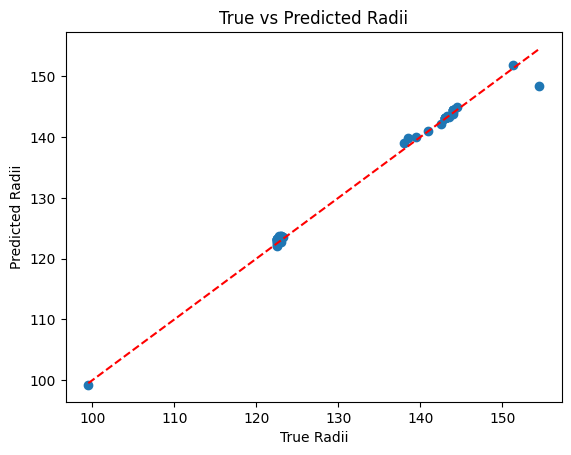

In [8]:
df = pd.read_excel('combined_results.xlsx')


image_paths = df['Image Path'].tolist()  
radii = df['center_x(crow)'].values       

img_height, img_width = 256, 256 #FIXED DImensions
images = []

for path in image_paths:
   
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  
    images.append(img_array)


images = np.array(images)  # Shape: (num_samples, img_height, img_width, 1)
radii = radii.reshape(-1, 1)  # Shape: (num_samples, 1)


x_train, x_val, radii_train, radii_val = train_test_split(
    images, radii, test_size=0.2, random_state=42
)

# autoencoder = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
test_images = x_val
reconstructed_images, predicted_radii = autoencoder.predict(test_images)


plt.scatter(radii_val, predicted_radii)
plt.plot([radii_val.min(), radii_val.max()], [radii_val.min(), radii_val.max()], color='r', linestyle='--')
plt.xlabel('True Radii')
plt.ylabel('Predicted Radii')
plt.title('True vs Predicted Radii')
plt.show()


# Loading the images of Test_Validation

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image, ImageOps
import os
from pathlib import Path

In [3]:
os.makedirs('tmp',exist_ok=True)

In [4]:
def preprocess_images(path):

    img_height, img_width = 256, 256
    img = load_img(path, target_size=(img_height, img_width), color_mode='grayscale')
    img_array = img_to_array(img) / 255.0  


    fig_dpi = 80  
    fig_width, fig_height = 8, 6  

    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=fig_dpi)

    ax.imshow(img_array, cmap='gray')

    plt.savefig('tmp/figure_with_border.png', dpi=fig_dpi)

    # plt.show()
    img = load_img('tmp/figure_with_border.png', target_size=(img_height, img_width), color_mode='grayscale')
    result = img_to_array(img) / 255.0  
    # os.remove('tmp/figure_with_border.png')
    return result


In [5]:
def draw_circle(file_path,path,radius,ccol,crow,filename):
        print(file_path)
        image=cv2.imread(file_path,cv2.IMREAD_GRAYSCALE)
        fig, ax = plt.subplots()
        ax.imshow(image, cmap='gray')
        circle_center=(ccol,crow)
        circle = patches.Circle(circle_center, radius, edgecolor='black', facecolor='none', linewidth=1)
        ax.add_patch(circle)

        cross_size = 10
        ax.plot([circle_center[0] - cross_size, circle_center[0] + cross_size], 
                [circle_center[1], circle_center[1]], color='white', linewidth=2) 
        ax.plot([circle_center[0], circle_center[0]], 
                [circle_center[1] - cross_size, circle_center[1] + cross_size], color='white', linewidth=2) 
        fig.savefig(os.path.join(path, f"result_{filename}"))
        print(os.path.join(path, f"result_{filename}"))
        plt.cla()
        plt.close(fig)
        plt.close('all')
        del fig,ax

In [6]:
def process_images(image,autoencoder_radius,autoencoder_ccol,autoencoder_crow):
    image = np.expand_dims(image, axis=0)

    image_tmp,radius=autoencoder_radius.predict(image)
    image_tmp_2,ccol=autoencoder_ccol.predict(image)
    image_tmp_3,crow=autoencoder_crow.predict(image)
    del image_tmp, image_tmp_2,image_tmp_3
    return radius[0][0],ccol[0][0],crow[0][0]

In [7]:
def find_circles(test_number,result_path,input_path,excel_path,autoencoder_radius,autoencoder_ccol,autoencoder_crow):
    output_path=Path(input_path)
    output_path.mkdir(parents=True, exist_ok=True)
    Path(result_path).mkdir(parents=True, exist_ok=True)
    Path(excel_path).mkdir(parents=True, exist_ok=True)

    excel_path+=f'/AutoencodersNoNCenter{test_number}.xlsx'

    filenames=os.listdir(output_path)

    df_list=[]
    i=0
    for filename in filenames:
        file_path = os.path.join(output_path, filename)
        image=cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        
        image=preprocess_images(file_path)
        # plt.imshow(image)
        # plt.show()
        print(image.shape)
        print(file_path)
        
        radius,ccol,crow = process_images(image,autoencoder_radius,autoencoder_ccol,autoencoder_crow)

        dfPrevData = pd.read_excel(f'Testing_ideas/ExcelsTesting/Video{test_number}_37_1_hough.xlsx')
        ccol = dfPrevData['center_y(ccol)'].values[i]
        crow = dfPrevData['center_x(crow)'].values[i]

        print(f'radius {radius} ccol {ccol} crow {crow}')
        draw_circle(file_path,result_path,radius,ccol,crow,filename)


        new_data = pd.DataFrame({
        'center_y(ccol)': [ccol],
        'center_x(crow)': [crow],
        'circle_radius': [radius]
        })

        df_list.append(new_data)
        i+=1

    df = pd.concat(df_list, ignore_index=True)
    df.to_excel(excel_path)
        
        

In [8]:
autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})
test=9
params={
    'test_number':test,
    'result_path':f"Results_Validation/{test}/" + f"_Results_bw_Video{test}",
    'input_path':f'Results_Validation/Video{test}/Video{test}',
    'excel_path':f'ExcelsTesting/Autoencoders/Video{test}',
    'autoencoder_radius':autoencoder_radius,
    'autoencoder_ccol':autoencoder_ccol,
    'autoencoder_crow':autoencoder_crow

    }
find_circles(**params)


(256, 256, 1)
Results_Validation\Video9\Video9\frame_000000.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step
radius 41.079490661621094 ccol 77.99106 crow 72.01393
Results_Validation\Video9\Video9\frame_000000.png
Results_Validation/9/_Results_bw_Video9\result_frame_000000.png
(256, 256, 1)
Results_Validation\Video9\Video9\frame_000001.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
radius 41.01937484741211 ccol 77.99303 crow 72.01366
Results_Validation\Video9\Video9\frame_000001.png
Results_Validation/9/_Results_bw_Video9\result_frame_000001.png
(256, 256, 1)
Results_Validation\Video9\Video9\frame_000002.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
radius 40.96458053588867 ccol 77.99059 crow 72.0142
Results_Validation\Video9\Video9\frame_000002.png
Results_Validation/9/_Resu

In [9]:
# autoencoder_radius = load_model('diffraction_autoencoder.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_ccol = load_model('diffraction_autoencoder_ccol.h5', custom_objects={'mse': MeanSquaredError()})
# autoencoder_crow = load_model('diffraction_autoencoder_crow.h5', custom_objects={'mse': MeanSquaredError()})

# for test in range(1,11):
#     params={
#         'test_number':test,
#         'result_path':f"Results_Validation/{test}/" + f"_Results_bw_Video{test}",
#         'input_path':f'Results_Validation/Video{test}/Video{test}',
#         'excel_path':f'ExcelsTesting/Autoencoders/Video{test}',
#         'autoencoder_radius':autoencoder_radius,
#         'autoencoder_ccol':autoencoder_ccol,
#         'autoencoder_crow':autoencoder_crow

#     }
#     try:
#         print(params)
#         find_circles(**params)
#     except Exception as e:
#         print(e)
#         continue
